In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr

In [22]:
scores = pklload(f"./database/08_nh_scores.pickle")
scores['take'][11]

{1867: array([1583.38139535, 1844.07486631,   17.00001738,   15.00001606,
           9.00001573,   11.00001506, 2106.0018018 ,   13.0000149 ,
          14.00001441, 1934.00226244,    9.00001441,   10.00001442,
          14.00001442,   12.00001442,   12.00001442,   12.00001443,
        1912.00140056,   13.00001427,   11.00001428,    8.00001429,
          10.00001412,   11.00001413,   12.00001413, 1980.00287356,
        1973.00228311, 1813.00301205, 1892.00689655, 2410.00310559,
        1839.00420168,   12.00001399,    7.000014  ,   12.000014  ,
          21.00001401,    9.00001401,   13.00001401, 2044.00179856,
          24.00001401, 2075.00318471,   16.00001403,   17.00001403,
          18.00001404,   12.00001404,   13.00001404,   36.00001405,
          14.00001407,   10.00001406,   15.00001407,   16.00001407,
          13.00001409,   20.00001409,   17.00001409,   12.00001409,
          19.00001409, 1988.00125   ,   16.00001394,   13.00001395,
          13.00001394,   15.00001396,    8

In [3]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals1 = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
gals2 = pklload("./database/01_nh_ghmatch.pickle")
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)
LG = pklload(f"./database/16_LocalGroup.pickle")
for key in LG.keys():
    satids = LG[key]['sats']['id']
    ind = isin(satids, LG[key]['real']['gid'])
    omitted = satids[~ind]
    assert len(omitted)==0, "orphaned satellites found"
    # if(len(omitted)>0):
    #     dtype = LG[key]['real'].dtype
    #     arr = np.zeros(len(omitted), dtype=dtype)
    #     arr['gid'] = omitted
    #     arr['state'] = 'orphan'
    #     LG[key]['real'] = np.hstack((LG[key]['real'], arr))

In [ ]:
[2]
	SAT684 is not real!
	SAT684 is not real!
	SAT726 is not real!
	SAT757 is not real!
	SAT757 is not real!
	SAT808 is not real!
	SAT808 is not real!
	SAT831 is not real!
	SAT831 is not real!
	SAT957 is not real!
	SAT971 is not real!
	SAT971 is not real!
	SAT1017 is not real!
	SAT1017 is not real!
	SAT1178 is not real!
	SAT1181 is not real!
	SAT1183 is not real!
	SAT1183 is not real!
	SAT1187 is not real!
	SAT1187 is not real!
	SAT1190 is not real!
	SAT1191 is not real!
	SAT1191 is not real!
	SAT1194 is not real!
	SAT1204 is not real!
	SAT2081 is not real!
	SAT2081 is not real!
	SAT2082 is not real!
	SAT2082 is not real!

In [16]:
result1s = pklload(f"./database/03_MWA1s.pickle")
tmp = result1s[result1s['id']==11][0]
tmp['r200_code'], tmp['r']

(6.086326651520674e-05, 0.00039020764078722395)

In [17]:
tmp.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('r200', '<f8'), ('m200', '<f8'), ('r200_code', '<f8'), (

In [15]:
result1s['id']

array([   1,    2,    3,    4,    7,    8,    9,   10,   11,   14,   17,
         19,   20,   21,   23,   24,   25,   26,   29,   35,   36,   37,
         40,   41,   46,   47,   52,   54,   60,   63,   64,   65,   66,
         68,   75,   84,   91,   92,  104,  107,  108,  121,  129,  133,
        136,  148,  165,  168,  207,  212,  937, 1252, 1545, 1920],
      dtype=int32)

In [18]:
LG[11]['BGG'].dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('r200', '<f8'), ('m200', '<f8'), ('r200_code', '<f8'), (

In [4]:
LG.keys()

dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 17, 23, 24, 25, 26, 29, 35, 36, 37, 40, 46, 47, 52, 63, 64, 75, 84, 92, 107, 108, 121, 129, 207])

In [4]:
LG[1]['subs']['id']

array([ 1324,  3797,  3885, 20705, 20708, 20709, 20710, 20716, 20717,
       20720, 20721, 20722, 20723, 20724, 20726, 20730, 20731, 20732,
       20733, 20734, 20735, 20736, 20737, 20738, 20739, 20742, 20743,
       20744, 20746, 20747, 20748, 20749, 20750, 20751, 20753, 20754,
       20756, 20757, 20758, 20760, 20762, 20763, 20764, 20766, 20767,
       20771, 20774, 20776, 20778, 20779, 20780, 20781, 20783, 20784,
       20785, 20787, 20790, 20792, 20794, 20795, 20798, 20799, 20800,
       20803, 20804, 20805, 20806, 20809, 20810, 20813, 20814, 20815,
       20817, 20820, 20823, 20824, 20826, 20827, 20829, 20830, 20831,
       20833, 20840], dtype=int32)

In [4]:
results = pklload(f"./database/03_MWA1s.pickle")
pairs = pklload(f"./database/06_nh_subhalo_pairs.pickle")
scores = pklload(f"./database/08_nh_scores.pickle")
scores['take'][3].keys()

dict_keys([110, 336, 617, 914, 995, 1000, 1050, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370])

In [5]:
pairs[3]

{'pair': [(22504, 110),
  (22477, 336),
  (22512, 617),
  (22499, 914),
  (22489, 995),
  (22514, 1000),
  (22518, 1050),
  (22511, 1250),
  (22517, 1252)],
 'sat_age': array([9.21573228e+00, 5.43475662e+00, 8.31706995e+00, 6.51515924e+00,
        6.25417193e+00, 5.10039688e+00, 8.58007121e+00, 9.55894441e+00,
        2.53875679e+00, 3.73524829e+00, 1.34426995e+00, 8.72922577e-01,
        2.30908380e+00, 9.10221351e-01, 2.05372394e+00, 1.66707566e+00,
        1.22315068e+00, 1.06121781e+00, 8.41419375e-01, 2.18959326e+00,
        2.01796479e+00, 1.72884806e+00, 1.40208819e+00, 4.33159932e-01,
        8.48459573e-01, 1.74635010e+00, 5.54878287e-01, 1.57143675e+00,
        1.40836496e+00, 5.84847936e-01, 9.51089181e-01, 1.85598099e+00,
        1.38820817e+00, 1.42791336e+00, 7.46412197e-01, 1.11646965e+00,
        5.56532192e-01, 7.51608076e-01, 1.82570552e+00, 1.47191182e+00,
        9.24385366e-01, 9.25608504e-01, 4.23313796e-01, 1.09277598e+00,
        1.45616604e+00, 2.46954648e-01, 

In [6]:
real_members = pklload(f"./database/10_real_members.pickle")
real_members[3]

array([[ 1775,     0],
       [22457,     0],
       [22460,     0],
       [22463,     0],
       [22468,     0],
       [22470,     0],
       [22472,     0],
       [22475,     0],
       [22476,     0],
       [22477,   336],
       [22478,     0],
       [22480,     0],
       [22481,     0],
       [22483,     0],
       [22485,     0],
       [22486,     0],
       [22487,     0],
       [22488,     0],
       [22489,   995],
       [22490,     0],
       [22491,     0],
       [22494,     0],
       [22495,     0],
       [22496,     0],
       [22497,     0],
       [22498,     0],
       [22499,   914],
       [22500,     0],
       [22501,     0],
       [22502,     0],
       [22503,     0],
       [22504,   110],
       [22505,     0],
       [22506,     0],
       [22507,     0],
       [22508,     0],
       [22510,     0],
       [22511,  1250],
       [22512,   617],
       [22513,     0],
       [22514,  1000],
       [22516,     0],
       [22517,  1252],
       [225

In [6]:
LG[1]['sats']['id']

array([ 178,  220,  226,  510,  575, 1115, 1116, 1117, 1122, 1144],
      dtype=int32)

In [7]:
LG[1]['real']['gid']

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  226,  510, 1116, 1117, 1122, 1144,  575,  220,  178,
       1115], dtype=int32)

In [3]:
bggs = None
for key in LG.keys():
    temp = LG[key]['BGG']
    bggs = temp if(bggs is None) else np.hstack((bggs, temp))

sats = None
for key in LG.keys():
    temp = LG[key]['sats']
    sats = temp if(sats is None) else np.hstack((sats, temp))

subs = None
for key in LG.keys():
    temp = LG[key]['subs']
    subs = temp if(subs is None) else np.hstack((subs, temp))

pairs = None
for key in LG.keys():
    temp = LG[key]['real']
    temp = temp[temp['state'] == 'pair']
    pairs = temp if(pairs is None) else np.hstack((pairs, temp))

In [4]:
mratios = pklload("./database/14_mass_in_sub.pickle")
mratios.dtype, mratios.shape

(dtype((numpy.record, [('host', '<i4'), ('sub', '<i4'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8')])),
 (2634,))

In [5]:
key = 1
myLG = LG[key]
print(myLG.keys())
bgg = myLG['BGG']
print(myLG['BGG'].dtype)

dict_keys(['BGG', 'neighbor', 'sats', 'subs', 'real'])
[('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('r200',

In [6]:
subs = myLG['subs']
reals = myLG['real']
dinks = reals[reals['state']=='dink']
pairs = reals[reals['state']=='pair']
orphans = reals[reals['state']=='orphan']
dinks

array([( 1324, 0, 'dink'), ( 3797, 0, 'dink'), ( 3885, 0, 'dink'),
       (20705, 0, 'dink'), (20708, 0, 'dink'), (20709, 0, 'dink'),
       (20710, 0, 'dink'), (20717, 0, 'dink'), (20720, 0, 'dink'),
       (20721, 0, 'dink'), (20722, 0, 'dink'), (20723, 0, 'dink'),
       (20724, 0, 'dink'), (20726, 0, 'dink'), (20730, 0, 'dink'),
       (20731, 0, 'dink'), (20732, 0, 'dink'), (20733, 0, 'dink'),
       (20734, 0, 'dink'), (20735, 0, 'dink'), (20736, 0, 'dink'),
       (20737, 0, 'dink'), (20738, 0, 'dink'), (20739, 0, 'dink'),
       (20742, 0, 'dink'), (20743, 0, 'dink'), (20744, 0, 'dink'),
       (20746, 0, 'dink'), (20747, 0, 'dink'), (20748, 0, 'dink'),
       (20749, 0, 'dink'), (20750, 0, 'dink'), (20751, 0, 'dink'),
       (20753, 0, 'dink'), (20754, 0, 'dink'), (20756, 0, 'dink'),
       (20757, 0, 'dink'), (20758, 0, 'dink'), (20760, 0, 'dink'),
       (20762, 0, 'dink'), (20763, 0, 'dink'), (20764, 0, 'dink'),
       (20766, 0, 'dink'), (20767, 0, 'dink'), (20771, 0, 'din

In [7]:
mratio = mratios[mratios['host'] == key]
argsort = np.argsort(mratio['sub'])
mratio = mratio[argsort]
mstar = mratio['mstar']
mcold = mratio['mcold']
mcell = mratio['mcell']
mdm = mratio['mdm']
isdinks = mratio['dink']

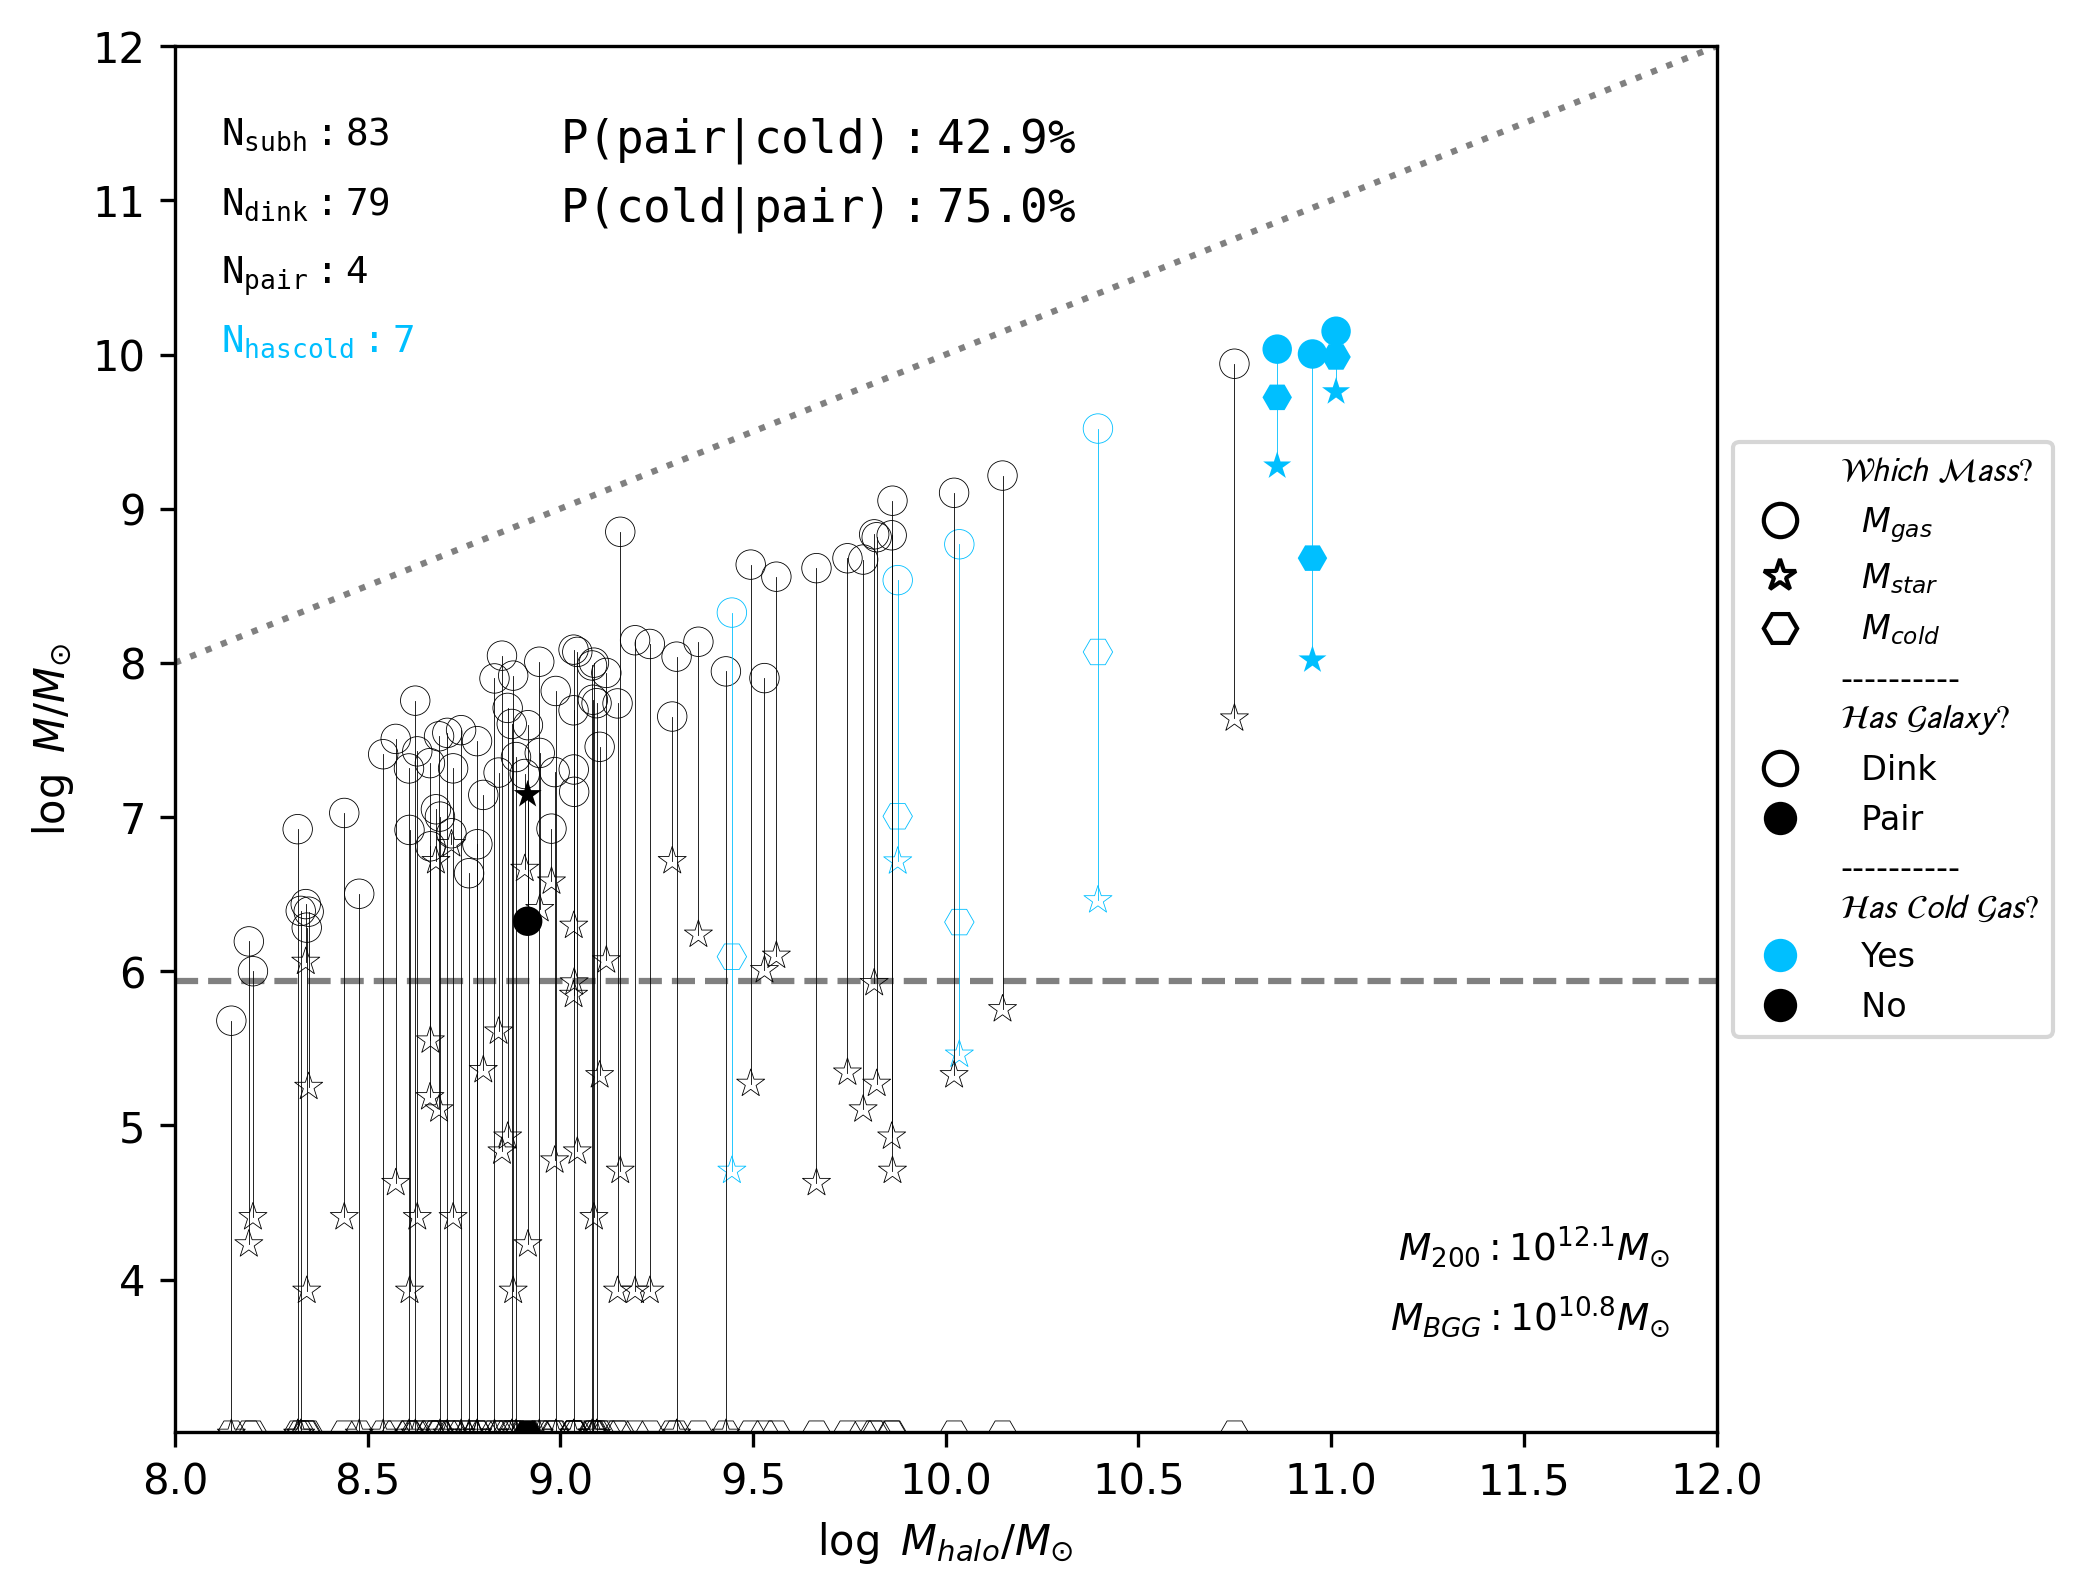

In [8]:
fig, ax = plt.subplots(dpi=300, figsize=(8,6))
for i,sub in enumerate(subs):
    isdink = isdinks[i]
    color = 'k' if(mcold[i]<=1e3) else 'deepskyblue'
    facecolor='none' if(isdink) else color
    edgecolor=color if(isdink) else 'none'
    linecolor=color

    ax.scatter(np.log10(mdm[i]), np.log10(mstar[i]), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=0.2, marker='*')
    ax.scatter(np.log10(mdm[i]), np.log10(mcold[i]), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=0.2, marker='H')
    ax.scatter(np.log10(mdm[i]), np.log10(mcell[i]), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=0.2)
    # ax.text(np.log10(mdm[i]), np.log10(mcell[i])+0.1,f"{sub['id']}", ha='center', va='bottom', fontsize=5)
    ax.plot([np.log10(mdm[i]),np.log10(mdm[i])], [np.log10(mstar[i]), np.log10(mcell[i])], color=linecolor, lw=0.2)

# 
ax.axhline(np.log10(np.min(gals1['m'])), ls='--', color='grey', zorder=-1)


ax.set_xlim(8,12)
xlim = ax.get_xlim()
ax.plot(xlim, xlim, ls=':', color='grey', zorder=-1)
ax.set_ylim(3.01,12)
ax.set_xlabel(r"$\log\ M_{halo}/M_{\odot}$")
ax.set_ylabel(r"$\log\ M/M_{\odot}$")

hascold = mcold > 1e3
haspair = isin(subs['id'], pairs['hid'])
ax.text(0.03, 0.95, fr"$\mathtt{{ N_{{subh}}: {len(subs)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.03, 0.90, fr"$\mathtt{{ N_{{dink}}: {len(dinks)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.03, 0.85, fr"$\mathtt{{ N_{{pair}}: {len(pairs)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.03, 0.80, fr"$\mathtt{{ N_{{has cold}}: {np.sum(hascold)} }}$", ha='left', va='top', color='deepskyblue', fontsize=9, transform=ax.transAxes)
ax.text(0.25, 0.95, fr"$\mathtt{{ P(pair|cold): {100*np.sum(haspair&hascold)/np.sum(hascold):.1f}\% }}$", ha='left', va='top', color='k', fontsize=11, transform=ax.transAxes)
ax.text(0.25, 0.90, fr"$\mathtt{{ P(cold|pair): {100*np.sum(haspair&hascold)/np.sum(haspair):.1f}\% }}$", ha='left', va='top', color='k', fontsize=11, transform=ax.transAxes)

ax.text(0.97, 0.15, fr"$M_{{200}}: 10^{{{np.log10(bgg['m200']):.1f}}} M_{{\odot}}$", ha='right', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.97, 0.10, fr"$M_{{BGG}}: 10^{{{np.log10(bgg['m']):.1f}}} M_{{\odot}}$", ha='right', va='top', color='k', fontsize=9, transform=ax.transAxes)

# Making Legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Which\ Mass?}$'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{gas}$'),
    Line2D([0],[0], marker='*',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{star}$'),
    Line2D([0],[0], marker='H',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{cold}$'),
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label="----------\n"+r'$\mathcal{Has\ Galaxy?}$'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label='  Dink'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='none', markerfacecolor='k', markersize=8, label='  Pair'),
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label="----------\n"+r'$\mathcal{Has\ Cold\ Gas?}$'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='none', markerfacecolor='deepskyblue', markersize=8, label='  Yes'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='none', markerfacecolor='k', markersize=8, label='  No'),
]
leg = ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
ax.set_aspect(1/2.5)
plt.savefig("test.png", dpi=400, facecolor='w')

In [9]:
isdinks = isin(subs['id'], dinks['hid'])
isdinks

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [10]:
mratio['dink']

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [11]:
mratios.shape, np.unique(mratios['sub']).shape

((2634,), (2595,))

In [16]:
LG.keys()

dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 17, 23, 24, 25, 26, 29, 35, 36, 37, 40, 46, 47, 52, 63, 64, 75, 84, 92, 107, 108, 121, 129, 207])

(8646258, 10, 1026, 1, 10, 0, 58, 1805, 0.85361391, 7.67504578e+10, 0.50512728, 0.54470694, 0.55605535, -6.51165676, 6.75259086, 55.61112774, 3.27934272e+10, 1.27246581e+10, 8.89685056e+10, 0.00064888, 0.00760735, 0.0072833, 0.00495106, 25392.82722842, -11527.74206087, 13865.08516756, 0.50753324, 210.78708621, 217.67922458, 0.27597048, 0.00064888, 7.67504321e+10, 150623.98361054, 64.77386789, 125.40622844, 0.00064888, 5461, 1179765, 1, 5461, 0, 0.50512719, 0.54470674, 0.55605543, -13.98621742, 0.7619477, 42.43158628, 1.62477542e+12, 0.00226896, 0.21624962, 2.35975764e-07, True, True, 206.59364605, 1.63371347e+12, 0.00170384, 8.01592802e+10, 9.46875981e+10, 0.19587868, 0.00015079, 2.63745916, 3.50827809, 3, 5656, 0.32127158)

In [21]:
LG[11]['subs']['id']

array([ 5661, 24574, 24593, 24601, 24604, 24608, 24611, 24613, 24615,
       24628, 24630, 24632, 24633, 24635, 24636, 24639, 24642, 24644,
       24649, 24650, 24651, 24652, 24653, 24656, 24657, 24658, 24659,
       24661, 24662, 24664, 24665, 24666, 24667, 24668, 24669, 24670,
       24671, 24672, 24674, 24679,  5461, 14253, 24202, 24233, 24248,
       24266, 24285, 24377, 24379, 24381, 24382, 24383, 24384, 24385,
       24386, 24387, 24388, 24390, 24391, 24395], dtype=int32)

In [23]:
LG[11]['neighbor']

array([(21, 1.4058576)], dtype=[('id', '<i4'), ('mratio', '<f8')])

In [24]:
LG[10]['neighbor']

array([(104, 7.57539167)], dtype=[('id', '<i4'), ('mratio', '<f8')])

In [22]:
LG[11]['real']['hid']

array([ 5461,  5661, 14253, 24202, 24233, 24248, 24266, 24285, 24377,
       24379, 24381, 24382, 24383, 24384, 24385, 24386, 24387, 24388,
       24390, 24391, 24395, 24574, 24593, 24601, 24604, 24608, 24611,
       24613, 24615, 24628, 24630, 24632, 24633, 24635, 24636, 24639,
       24642, 24644, 24650, 24651, 24653, 24656, 24657, 24658, 24659,
       24661, 24664, 24665, 24667, 24669, 24670, 24672, 24674, 24679,
           0, 24649, 24652, 24662, 24666, 24668, 24671, 24673],
      dtype=int32)

In [19]:
mratios[mratios['host']==11]

rec.array([(11,  5461,  True, 0.00000000e+00, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03),
           (11,  5661,  True, 1.59447404e+08, 1.00000000e+03, 1.00000000e+03, 1.71011779e+07),
           (11, 14253,  True, 0.00000000e+00, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03),
           (11, 24202,  True, 0.00000000e+00, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03),
           (11, 24233,  True, 0.00000000e+00, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03),
           (11, 24248,  True, 0.00000000e+00, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03),
           (11, 24266,  True, 0.00000000e+00, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03),
           (11, 24285,  True, 0.00000000e+00, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03),
           (11, 24377,  True, 0.00000000e+00, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03),
           (11, 24379,  True, 0.00000000e+00, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03),
           (11, 24381,  True, 0.00000000e+00, 1.00

In [15]:
unique, count = np.unique(mratios['sub'], return_counts=True)
for uni, cou in zip(unique, count):
    if(cou>1):
        tmp = mratios['sub']==uni
        print(mratios[tmp])

[(46, 11047,  True, 1.03344292e+12, 2.8421232e+10, 1.94025385e+10, 8.63184476e+10)
 (46, 11047,  True, 1.03344292e+12, 2.8421232e+10, 1.94025385e+10, 8.63184476e+10)]
[(10, 14253,  True, 4.43623824e+08, 1000., 1000., 3.52340868e+07)
 (11, 14253,  True, 0.00000000e+00, 1000., 1000., 1.00000000e+03)]
[(4, 19583,  True, 4.89120341e+11, 1.48228581e+10, 9.43574126e+09, 4.31636172e+10)
 (4, 19583,  True, 4.89120341e+11, 1.48228581e+10, 9.43574126e+09, 4.31636172e+10)]
[(4, 19690,  True, 1.51693631e+10, 14069241.99368623, 38926318.00687279, 1.56686987e+09)
 (4, 19690,  True, 1.51693631e+10, 14069241.99368623, 38926318.00687279, 1.56686987e+09)]
[(4, 19699,  True, 2.2115612e+10, 59620740.89141523, 9.13698945e+08, 2.06844573e+09)
 (4, 19699,  True, 2.2115612e+10, 59620740.89141523, 9.13698945e+08, 2.06844573e+09)]
[(4, 19780,  True, 6.3448108e+11, 2.82674107e+10, 2.37425778e+10, 5.47558908e+10)
 (4, 19780,  True, 6.3448108e+11, 2.82674107e+10, 2.37425778e+10, 5.47558908e+10)]
[(4, 19999,  True,

In [19]:
dink_subs = subs[isdinks]
dink_mcell = mcell[isdinks]
dink_mcold = mcold[isdinks]
dink_mstar = mstar[isdinks]
dink_mdm = mdm[isdinks]
dink_mbary = dink_mcell+dink_mstar
dink_mtot = dink_mbary+dink_mdm

pair_subs = subs[~isdinks]
pair_mcell = mcell[~isdinks]
pair_mcold = mcold[~isdinks]
pair_mstar = mstar[~isdinks]
pair_mdm = mdm[~isdinks]
pair_mbary = pair_mcell+pair_mstar
pair_mtot = pair_mbary+pair_mdm

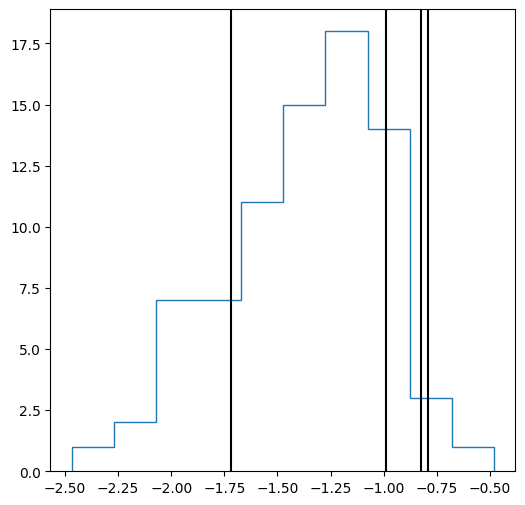

In [20]:
fig, ax = plt.subplots(figsize=(6,6), dpi=100)

ax.hist(np.log10(dink_mbary/dink_mtot), histtype='step')
for i_mbary, i_mtot in zip(pair_mbary, pair_mtot):
    ax.axvline(np.log10(i_mbary/i_mtot), color='k')

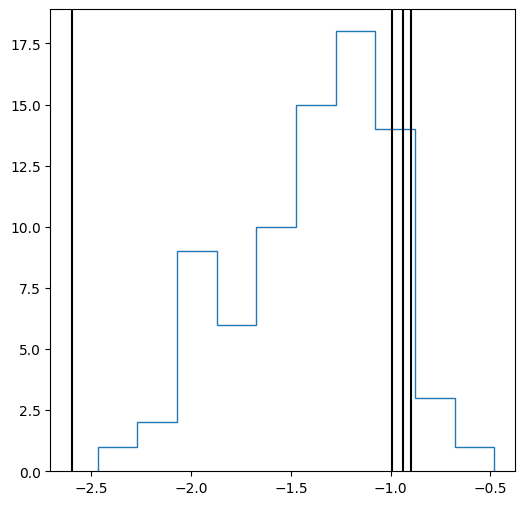

In [24]:
fig, ax = plt.subplots(figsize=(6,6), dpi=100)

ax.hist(np.log10(dink_mcell/dink_mtot), histtype='step')
for i_mcell, i_mtot in zip(pair_mcell, pair_mtot):
    ax.axvline(np.log10(i_mcell/i_mtot), color='k')

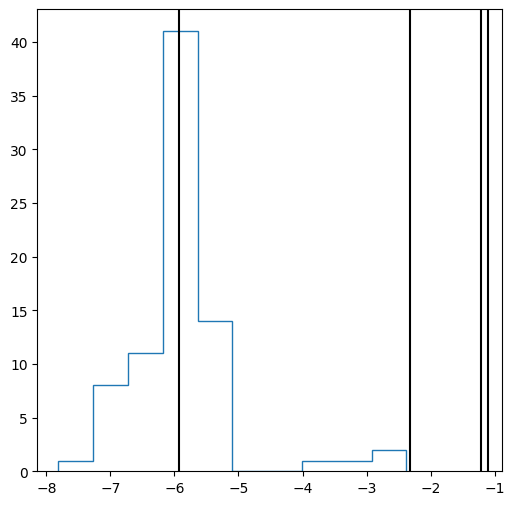

In [25]:
fig, ax = plt.subplots(figsize=(6,6), dpi=100)

ax.hist(np.log10(dink_mcold/dink_mtot), histtype='step')
for i_mcold, i_mtot in zip(pair_mcold, pair_mtot):
    ax.axvline(np.log10(i_mcold/i_mtot), color='k')

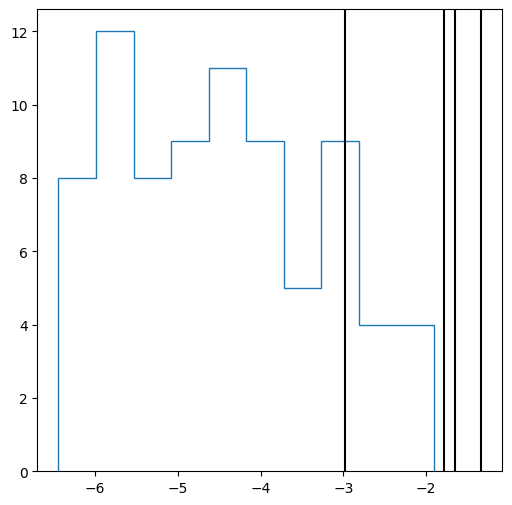

In [26]:
fig, ax = plt.subplots(figsize=(6,6), dpi=100)

ax.hist(np.log10(dink_mstar/dink_mtot), histtype='step')
for i_mstar, i_mtot in zip(pair_mstar, pair_mtot):
    ax.axvline(np.log10(i_mstar/i_mtot), color='k')

In [16]:
myLG['sats']['id']

array([ 178,  220,  226,  510,  575, 1115, 1116, 1117, 1122, 1144],
      dtype=int32)

In [17]:
myLG['subs']['id']

array([ 1278,  1310,  1324,  1940,  1941,  3484,  3797,  3802,  3885,
        5008, 20689, 20699, 20700, 20705, 20706, 20708, 20709, 20710,
       20713, 20714, 20716, 20717, 20718, 20720, 20721, 20722, 20723,
       20724, 20726, 20727, 20730, 20731, 20732, 20733, 20734, 20735,
       20736, 20737, 20738, 20739, 20742, 20743, 20744, 20746, 20747,
       20748, 20749, 20750, 20751, 20753, 20754, 20756, 20757, 20758,
       20760, 20762, 20763, 20764, 20766, 20767, 20771, 20774, 20776,
       20778, 20779, 20780, 20781, 20783, 20784, 20785, 20787, 20790,
       20792, 20794, 20795, 20798, 20799, 20800, 20803, 20804, 20805,
       20806, 20809, 20810, 20813, 20814, 20815, 20817, 20820, 20823,
       20824, 20826, 20827, 20829, 20830, 20831, 20833, 20836, 20840,
       20842, 20844], dtype=int32)